<h1>Convolutional Neural Network Classification with Fashion MNIST</h1> 


In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

In [2]:
def show_data(data_sample):
    plt.imshow(data_sample[0][0].numpy(), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))
    plt.show()

<h2 id="Makeup_Data">Get the Data</h2> 


In [3]:
#Hint:

IMAGE_SIZE = 28

transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
transforms.ToTensor()#
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

(Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR),)

ToTensor()

In [4]:
train_dataset  = dsets.FashionMNIST(root='./data/fashionmnist_data/',train=True,download=True,transform=composed)

In [5]:
validation_dataset  = dsets.FashionMNIST(root='./data/fashionmnist_data/',train=False,download=True,transform=composed)

In [6]:
class_label = set([label for (_,label) in  train_dataset])

In [7]:
class_label

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
num_classes = len(class_label)

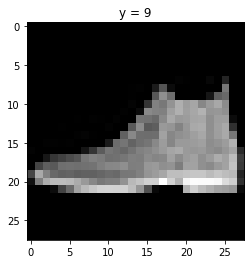

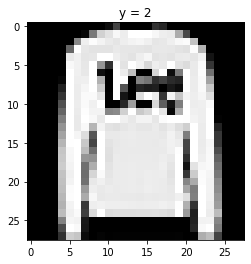

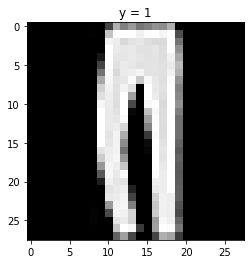

In [9]:
for index in range(3):
    show_data(validation_dataset[index])


In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [11]:
test_sample = next(iter(train_loader))[0]

In [12]:
test_sample.shape

torch.Size([64, 1, 28, 28])

<!--Empty Space for separating topics-->


In [13]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [14]:
out=conv_output_shape((28,28), kernel_size=5, stride=1, pad=0) ### conv2d
print("first conv2d:",out)
out=conv_output_shape(out, kernel_size=2, stride=2, pad=0) ### max_pool
print("first max pool:",out)

out=conv_output_shape(out, kernel_size=5, stride=2, pad=0) ### max_pool
print("second conv2d:",out)
out=conv_output_shape(out, kernel_size=2, stride=1, pad=0) ### max_pool
print("second max pool:",out)

first conv2d: (24, 24)
first max pool: (12, 12)
second conv2d: (4, 4)
second max pool: (3, 3)


In [15]:
class CNN_classifier(nn.Module):
    
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_classifier, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, stride = 1,padding=0)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=2, padding=0)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=1)
        
        self.fc1 = nn.Linear(out_2 * 3 * 3, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,number_of_classes)
        self.bn_fc2 = nn.BatchNorm1d(number_of_classes)
        
    
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        
        x = self.fc2(x)
        x=self.bn_fc2(x)
        return x

In [16]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    N_test=len(validation_dataset)
    # N_train=len()
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        print()
        print("EPOCH {}".format(epoch))
        for x, y in tqdm(train_loader):
            x,y = x.to(device),y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            x_test,y_test = x_test.to(device),y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        print("Test Accuracy:{:.2f}".format(accuracy))
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2> 


In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.device('cuda:0')

In [19]:
model = CNN_classifier(out_1=28, out_2=32)

In [20]:
model = model.to(device)

In [21]:
model

CNN_classifier(
  (cnn1): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(28, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=256, bias=True)
  (bn_fc1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (bn_fc2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Define the loss function, the optimizer and the dataset loader 


In [22]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate,momentum=0.1)

In [23]:
# Train the model
accuracy_list, loss_list=train_model(model=model,n_epochs=15,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]


EPOCH 0


  1%|          | 7/938 [00:00<00:14, 62.77it/s]

Test Accuracy:0.86

EPOCH 1


  1%|          | 7/938 [00:00<00:15, 61.74it/s]

Test Accuracy:0.87

EPOCH 2


  1%|          | 6/938 [00:00<00:17, 52.71it/s]

Test Accuracy:0.87

EPOCH 3


  1%|          | 6/938 [00:00<00:15, 59.83it/s]

Test Accuracy:0.88

EPOCH 4


  1%|          | 7/938 [00:00<00:14, 62.20it/s]

Test Accuracy:0.88

EPOCH 5


  1%|          | 7/938 [00:00<00:13, 68.92it/s]

Test Accuracy:0.88

EPOCH 6


  1%|          | 8/938 [00:00<00:12, 72.42it/s]

Test Accuracy:0.88

EPOCH 7


  1%|          | 8/938 [00:00<00:12, 72.51it/s]

Test Accuracy:0.88

EPOCH 8


  1%|          | 6/938 [00:00<00:16, 55.77it/s]

Test Accuracy:0.88

EPOCH 9


  1%|          | 5/938 [00:00<00:20, 45.05it/s]

Test Accuracy:0.88

EPOCH 10


  1%|          | 6/938 [00:00<00:17, 53.65it/s]

Test Accuracy:0.88

EPOCH 11


  1%|          | 7/938 [00:00<00:14, 66.37it/s]

Test Accuracy:0.88

EPOCH 12


  1%|          | 7/938 [00:00<00:13, 67.26it/s]

Test Accuracy:0.88

EPOCH 13


  1%|▏         | 13/938 [00:00<00:14, 61.94it/s]

Test Accuracy:0.88

EPOCH 14


100%|██████████| 938/938 [00:13<00:00, 67.59it/s]


Test Accuracy:0.88


<!--Empty Space for separating topics-->


<h2 id="Result">Analyze Results</h2> 


Plot the loss with both networks.


In [24]:
def plot_result(loss, accuracy):
    results ={"Loss":loss, "Accuracy":accuracy}
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(loss,color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis = 'y', color=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(accuracy, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()   

In [26]:

# accuracy_list

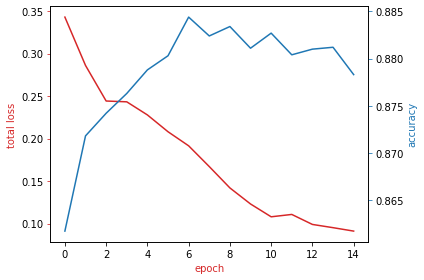

In [27]:
plot_result(loss_list,accuracy_list)


<!--Empty Space for separating topics-->
